## Extended Kalman Filter (EKF) to Localise Vehicle Position Based on LIDAR Data
-----

### GOAL

Recursively estimate the position of a vehicle along a trajectory using available measurements and a motion model. 

### Assumptions

1. The vehicle is equipped with a very simple type of LIDAR sensor, which returns:
    - Range ($r$) 
    - Bearing Measurements ($\phi$)
    
      Corresponding to individual landmarks in the environment. 
    
2. The global positions of the landmarks are assumed to be known beforehand.

3. We will also assume known data association, that is, which measurment belong to which landmark.

### Motion Models
---
#### Inputs

The vehicle motion model recieves the following inputs:

1. Linear Velocity ($v$) 

2. Angular Velocity ($\omega$)

Which are odometry readings.

#### Outputs 

The output is the 2-D pose of the vehicle $\mathbf{x}_k = \left[ x \, y \, \theta \right]^T$

1. $\mathbf{v}_k$ - Linear Velocity and $\mathbf{\omega}_k$ - Angular Velocity which we use as inputs to the model.
2. $\mathbf{w}_k$ - Process Noise which has zero mean, normal distribution with a constant covariance $\mathbf{Q}$.


\begin{align}
\mathbf{x}_k =  f(x_{k-1} , u_{k-1} , w_{k-1}) 
\end{align}

\begin{align}
\mathbf{x}_{k} &= \mathbf{x}_{k-1} + T
\begin{bmatrix}
\cos\theta_{k-1} &0 \\
\sin\theta_{k-1} &0 \\
0 &1
\end{bmatrix}
\left(
\begin{bmatrix}
v_k \\
\omega_k
\end{bmatrix}
+ \mathbf{w}_k
\right)
\, , \, \, \, \, \, \mathbf{w}_k = \mathcal{N}\left(\mathbf{0}, \mathbf{Q}\right)
\end{align}

### Measurement Models
---

#### Inputs

The LIDAR range and bearing measurements $\mathbf{y}^l_k = \left[r \, \phi \right]^T$.

1. ($x_k$,$y_k$) \& $\theta_{k}$ - Current Pose of the Vehicle.
2. ($x_l$, $y_l$) - Ground Truth Co-ordinates of the landmark ($l$).
3. $d$ - Distance between robot center and (LIDAR).
4. $\mathbf{n}^l_k$ - Measurement Noise with zero mean, normal distribution with a constant covariance $\mathbf{R}$.


\begin{align}
\mathbf{y}^l_k =
\begin{bmatrix}
\sqrt{(x_l - x_k - d\cos\theta_{k})^2 + (y_l - y_k - d\sin\theta_{k})^2} \\
atan2\left(y_l - y_k - d\sin\theta_{k},x_l - x_k - d\cos\theta_{k}\right) - \theta_k
\end{bmatrix}
+
\mathbf{n}^l_k
\, , \, \, \, \, \, \mathbf{n}^l_k = \mathcal{N}\left(\mathbf{0}, \mathbf{R}\right)
\end{align}


### EKF Algorithm
-----

Models above are Non-Linea we willl use EKF as the state estimator 

#### 1. Prediction Step
 
 - Using inputs and the motion model we produce: 
     - State Estimate at a given timestep.
     - Covariance Estimate at a given timestep.
     
#### 2. Correction Step

- Using the measurements provided by the LIDAR we will $correct$:
    - Pose estimate
    - Pose covariance estimate

### LIDAR Data
---

The LIDAR data is store in the file "data.pickle" we will unpack the data and store it into variables as below.

In [1]:
import pickle
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy import eye, matrix
from sympy import symbols
from sympy import Matrix

with open('data/data.pickle', 'rb') as f:
    data = pickle.load(f)

t = data['t']  # timestamps [s]

x_init  = data['x_init'] # initial x position [m]
y_init  = data['y_init'] # initial y position [m]
th_init = data['th_init'] # initial theta position [rad]

# input signal
v  = data['v']  # translational velocity input [m/s]
om = data['om']  # rotational velocity input [rad/s]

# bearing and range measurements, LIDAR constants
bearing = data['b']  # bearing to each landmarks center in the frame attached to the laser [rad]
ranging = data['r']  # range measurements [m]
xyLand = data['l']  # x,y positions of landmarks [m]
d = data['d']  # distance between robot center and laser rangefinder [m]

In [2]:
print('No. of Timestamps: ',t.shape[0])
print('No. of Linear Velo Measurements: ',v.shape[0])
print('No. of Angular Velo Measurements: ',om.shape[0])
print('No. of Bearing Measurements: ',bearing.shape[0])
print('No. of Range Measurements: ',ranging.shape[0])
print('No. of Landmark Measurements: ',xyLand.shape[0])
print('Distance between Robot Center and LIDAR: ',d.shape[0])

No. of Timestamps:  501
No. of Linear Velo Measurements:  501
No. of Angular Velo Measurements:  501
No. of Bearing Measurements:  501
No. of Range Measurements:  501
No. of Landmark Measurements:  8
Distance between Robot Center and LIDAR:  1


### Ground Truth
- Plot the ground truth position and orientation. 
- Orientation values are wrapped to the $\left[-\pi,\pi\right]$ range in radians.

<table><tr>
<td> <img src="data/gtruth.png" alt="Ground Truth" width="350"/> </td>
<td> <img src="data/gtruth2.png" alt="Ground Truth" width="350"/> </td>
</tr></table>

## Initializing Parameters
---

- It is neccessary to tune the measurement noise variances `r_var`, `b_var` in order for the filter to perform well.
- For the orientation estimates to coincide with the bearing measurements, it is also neccessary to wrap all estimated $\theta$ values to the $(-\pi , \pi]$ range.

In [3]:
# Wraps angle to (-pi,pi] range
def wraptopi(x):
    if x > np.pi:
        x = x - (np.floor(x / (2 * np.pi)) + 1) * 2 * np.pi
    elif x < -np.pi:
        x = x + (np.floor(x / (-2 * np.pi)) + 1) * 2 * np.pi
    return x

In [4]:
v_var = 0.01  # linear velocity variance  
om_var = 0.01  # angular velocity variance 
r_var = 0.1  # range measurements variance
b_var = 0.1  # bearing measurement variance

Q_k = np.diag([v_var, om_var]) # input noise covariance 
Rk = np.diag([r_var, b_var])  # measurement noise covariance 

x_est = np.zeros([len(v), 3])  # estimated states, x, y, and theta
P_est = np.zeros([len(v), 3, 3])  # state covariance matrices

x_est[0] = np.array([x_init, y_init, th_init]) # initial state
P_est[0] = np.diag([1, 1, 0.1]) # initial state covariance

In [5]:
print('Input Noise Co-Variance (W_k): \n\n',Q_k)
print('\n Measurement Noise Co-Variance (R_k): \n\n',Rk)
print('\n Initialised Estimated State Vector (x[0,] y[0], theta[0]) (501x3 - Matrix): \n\n',x_est[0])
print('\n Initialised State Covariance (P_k) (3x3 - Matrix for every state) (We have total 501): \n\n',P_est[0])

Input Noise Co-Variance (W_k): 

 [[0.01 0.  ]
 [0.   0.01]]

 Measurement Noise Co-Variance (R_k): 

 [[0.1 0. ]
 [0.  0.1]]

 Initialised Estimated State Vector (x[0,] y[0], theta[0]) (501x3 - Matrix): 

 [50.          0.          1.57079633]

 Initialised State Covariance (P_k) (3x3 - Matrix for every state) (We have total 501): 

 [[1.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.  0.1]]


## Correction Step
-----
The measurement update function, which takes:

1. Takes available landmark measurement ($l$).
2. Updates the current state estimate $\mathbf{\check{x}}_k$.


#### 1. Compute the measurement model Jacobians at   ($\mathbf{\check{x}}_{k}$)
---
\begin{align}
\mathbf{y}^l_k = &\mathbf{h}(\mathbf{x}_{k}, \mathbf{n}^l_k) \
\, 
\end{align}


\begin{align}
 \\
\mathbf{y}^l_k =
\begin{bmatrix}
\sqrt{(x_l - x_k - d\cos\theta_{k})^2 + (y_l - y_k - d\sin\theta_{k})^2} \\
atan2\left(y_l - y_k - d\sin\theta_{k},x_l - x_k - d\cos\theta_{k}\right) - \theta_k
\end{bmatrix}
+
\mathbf{n}^l_k
\, , \, \, \, \, \, \mathbf{n}^l_k = \mathcal{N}\left(\mathbf{0}, \mathbf{R}\right)
\end{align}

\begin{align}
 \\
\mathbf{H}_{k} = \frac{\partial \mathbf{h}}{\partial \mathbf{x}_{k}}\bigg|_{\mathbf{\check{x}}_{k},0}& \, , \, \, \, \,
\mathbf{M}_{k} = \frac{\partial \mathbf{h}}{\partial \mathbf{n}_{k}}\bigg|_{\mathbf{\check{x}}_{k},0} \, .
\end{align}


In [6]:
x_k, y_k, theta_k, x_l, y_l, d, n_k = symbols('x_k, y_k, theta_k, x_l, y_l, d, n_k')
x_curr, y_curr, theta_curr = symbols('x_curr, y_curr, theta_curr')
v_k, omega_k, w_k = symbols('v_k, omega_k, w_k')
x = (x_l - x_k - (d * sp.cos(theta_k)))
y = (y_l - y_k - (d * sp.sin(theta_k)))
h = Matrix([[sp.sqrt(x**2 + y**2)],
            [sp.atan2(y, x) - theta_k]])
f = Matrix([[sp.cos(theta_curr)],
            [sp.sin(theta_curr)],
            [0]])

n = Matrix([[sp.cos(theta_curr)],
            [sp.sin(theta_curr)],
            [0]])

---
##### Linearised Meaurement Model Matrix ($\mathbf{{H}}_{k}$)
\begin{align}
 \\
\mathbf{H}_{k} = \frac{\partial \mathbf{h}}{\partial \mathbf{x}_{k}}\bigg|_{\mathbf{\check{x}}_{k},0}& \, , \, \, \, \,
\end{align}


In [7]:
print('Meaurement Model Matrix (h): ')
h

Meaurement Model Matrix (h): 


Matrix([
[ sqrt((-d*sin(theta_k) - y_k + y_l)**2 + (-d*cos(theta_k) - x_k + x_l)**2)],
[-theta_k + atan2(-d*sin(theta_k) - y_k + y_l, -d*cos(theta_k) - x_k + x_l)]])

In [8]:
print(' Linearised Meaurement Model Matrix (H_k): ')
h.jacobian(Matrix([x_k, y_k, theta_k]))

 Linearised Meaurement Model Matrix (H_k): 


Matrix([
[(d*cos(theta_k) + x_k - x_l)/sqrt((-d*sin(theta_k) - y_k + y_l)**2 + (-d*cos(theta_k) - x_k + x_l)**2), (d*sin(theta_k) + y_k - y_l)/sqrt((-d*sin(theta_k) - y_k + y_l)**2 + (-d*cos(theta_k) - x_k + x_l)**2),                                                                   (-d*(-d*sin(theta_k) - y_k + y_l)*cos(theta_k) + d*(-d*cos(theta_k) - x_k + x_l)*sin(theta_k))/sqrt((-d*sin(theta_k) - y_k + y_l)**2 + (-d*cos(theta_k) - x_k + x_l)**2)],
[   -(d*sin(theta_k) + y_k - y_l)/((-d*sin(theta_k) - y_k + y_l)**2 + (-d*cos(theta_k) - x_k + x_l)**2),   -(-d*cos(theta_k) - x_k + x_l)/((-d*sin(theta_k) - y_k + y_l)**2 + (-d*cos(theta_k) - x_k + x_l)**2), d*(d*sin(theta_k) + y_k - y_l)*sin(theta_k)/((-d*sin(theta_k) - y_k + y_l)**2 + (-d*cos(theta_k) - x_k + x_l)**2) - d*(-d*cos(theta_k) - x_k + x_l)*cos(theta_k)/((-d*sin(theta_k) - y_k + y_l)**2 + (-d*cos(theta_k) - x_k + x_l)**2) - 1]])

----
##### Linearised Meaurement Model Noise Matrix ($\mathbf{{M}}_{k}$)
\begin{align}
 \\
\mathbf{M}_{k} = \frac{\partial \mathbf{h}}{\partial \mathbf{n}_{k}}\bigg|_{\mathbf{\check{x}}_{k},0} \, .
\end{align}


In [22]:
# This matrix usually has a value = 1 because in general M_k doesnt exist in the formula to caluclate the Kalman Gain
# But in this course they added. In my opinion dh/dn_k is also incorrect. 
M_k = Matrix([[1,0],
            [0,1]])
M_k

Matrix([
[1, 0],
[0, 1]])

#### 2. Compute the Kalman Gain
---
\begin{align}
\mathbf{K}_k &= \mathbf{\check{P}}_k \mathbf{H}_k^T \left(\mathbf{H}_k \mathbf{\check{P}}_k \mathbf{H}_k^T + \mathbf{M}_k \mathbf{R}_k \mathbf{M}_k^T \right)^{-1} 
\end{align}

----
##### Noise Co-Variance Matrix ($\mathbf{{R}}_{k}$)

\begin{align}
 \\
\mathbf{R}_k =
\begin{bmatrix}
{\sigma^2_{Range} \,\,\,\,\    \,\,\,\,\,\,\,\,\,\,\ 0} \\
 0 \,\,\,\,\,\,\,\,\,\  \sigma^2_{Bearing}
\end{bmatrix}
\\
\end{align}



In [10]:
R_k = Matrix([[r_var, 0],
              [  0  , b_var]])
R_k

Matrix([
[0.1,   0],
[  0, 0.1]])

#### 3. Correct the Predicted State
---
##### The correction will take place when we make a measurement.
- We use the measurement model to find what we will measure ($\mathbf{y}^l_k$)

\begin{align}
 \\
\mathbf{y}^l_k =
\begin{bmatrix}
\sqrt{(x_l - x_k - d\cos\theta_{k})^2 + (y_l - y_k - d\sin\theta_{k})^2} \\
atan2\left(y_l - y_k - d\sin\theta_{k},x_l - x_k - d\cos\theta_{k}\right) - \theta_k
\end{bmatrix}
+
\mathbf{n}^l_k
\, , \, \, \, \, \, \mathbf{n}^l_k = \mathcal{N}\left(\mathbf{0}, \mathbf{R}\right)
\end{align}

- We actually take the measurement ($\mathbf{\check{y}}^l_k$)

\begin{align}
 \
\mathbf{\check{y}}^l_k =
\begin{bmatrix}
Ranging \\
Bearing
\end{bmatrix}
\
\end{align}

- Then we compute the corrected state vector ($\mathbf{\hat{x}}_k$)
\begin{align}
\mathbf{\hat{x}}_k &= \mathbf{\check{x}}_k + \mathbf{K}_k \left(\mathbf{y}^l_k - \mathbf{\check{y}}^l_k\right)
\end{align}


#### 4. Correct the Co-Variance ($\mathbf{{P}}_{k}$) of State Vector ($\mathbf{{x}}_{k}$) after the Correction
---
\begin{align}
\mathbf{\hat{P}}_k &= \left(\mathbf{I} - \mathbf{K}_k \mathbf{H}_k \right)\mathbf{\check{P}}_k
\end{align}

- Here I = 3x3 Identity Matrix

In [11]:
def measurement_update(xyLand, ranging, bearing, P_check, x_check):
    
    """ 1. Compute measurement Jacobian """
    
    # Values from the State Vector (x_k)
    x_k = x_check[0]
    y_k = x_check[1]
    th_k = wraptopi(x_check[2])
    
    # Values from the Measurement Vector (y_k)
    x_l = xyLand[0]
    y_l = xyLand[1]
    d = 0
        
    ### Linearised Meaurement Model Matrix (H_k) ###
    a = x_l - x_k - (d * np.cos(th_k)) 
    b = - x_l + x_k + (d * np.cos(th_k))
    c = y_l - y_k - (d * np.sin(th_k)) 
    e = - y_l + y_k + (d * np.sin(th_k)) 
    DEN = (a**2 + c**2)
    
    H_k = np.zeros((2,3))
    
    H_k[0,0] = b/np.sqrt(DEN)
    H_k[0,1] = e/np.sqrt(DEN)
    H_k[0,2] = ((-d*np.cos(th_k)*c)+(d*np.sin(th_k)*a))/np.sqrt(DEN)
    H_k[1,0] = (-e)/DEN
    H_k[1,1] = (-a)/DEN
    H_k[1,2] = ((d*np.sin(th_k)*e)-(d*np.cos(th_k)*a))/DEN
    
       
    M_k = np.identity(2)
    
    """" 2. Compute Kalman Gain """
    
    # Noise Co-Variance Matrix (R_k) - Is defined above
    
    K_k = P_check.dot(H_k.T).dot(inv(H_k.dot(P_check).dot(H_k.T) + M_k.dot(Rk).dot(M_k.T)))

    """ 3. Correct Predicted State (Wrap Angles to [-pi,pi]) """
    
    # We will use the actual Non-Linear Measurment Model
    Y_k = np.zeros((2,1))
    
    Y_k[0,0] = np.sqrt(DEN)
    Y_k[1,0] = wraptopi(np.arctan2(c,a) - th_k)
    
    
    # Measusing Values (Correction will take place when we make a measurement)
    Y_Measured = np.zeros((2,1))
    
    Y_Measured[0,0] = ranging
    Y_Measured[1,0] = wraptopi(bearing)
    
    # Correction to the State Vector
    x_check = x_check + K_k.dot(Y_Measured - Y_k)
    # Limiting theta
    x_check[2] = wraptopi(x_check[2])
        
    """ 4. Correct covariance  """
    
    P_check = (np.identity(3) - K_k.dot(H_k)).dot(P_check)
    
    
    return x_check, P_check


## Prediction Step
-----
Now, implement the main filter loop, defining the prediction step of the EKF using the motion model provided:

\begin{align}
\mathbf{\check{x}}_k &= \mathbf{f}\left(\mathbf{\hat{x}}_{k-1}, \mathbf{u}_{k-1}, \mathbf{0} \right) \\
\mathbf{\check{P}}_k &= (\mathbf{F}_{k-1}\mathbf{\hat{P}}_{k-1}\mathbf{F}_{k-1}^T + \mathbf{L}_{k-1}\mathbf{Q}_{k-1}\mathbf{L}_{k-1}^T) \, .
\end{align}

Where

\begin{align}
\mathbf{F}_{k-1} = \frac{\partial \mathbf{f}}{\partial \mathbf{x}_{k-1}}\bigg|_{\mathbf{\hat{x}}_{k-1},\mathbf{u}_{k},0}  \, , \, \, \, \,
\mathbf{L}_{k-1} = \frac{\partial \mathbf{f}}{\partial \mathbf{u}_{k}}\bigg|_{\mathbf{\hat{x}}_{k-1},\mathbf{u}_{k},0} \, .
\end{align}

In [12]:
x_k, y_k, theta_k, x_l, y_l, d, n_k = symbols('x_k, y_k, theta_k, x_l, y_l, d, n_k')
x_curr, y_curr, theta_curr = symbols('x_curr, y_curr, theta_curr')
v_k, omega_k, w_k, T = symbols('v_k, omega_k, w_k, T')
f = Matrix([[x_curr + T*(v_k)*sp.cos(theta_curr)],
            [y_curr + T*(v_k)*sp.sin(theta_curr)],
            [theta_curr + T*(omega_k)]])
print('Meaurement Motion Matrix (f): ')
f

Meaurement Motion Matrix (f): 


Matrix([
[T*v_k*cos(theta_curr) + x_curr],
[T*v_k*sin(theta_curr) + y_curr],
[        T*omega_k + theta_curr]])

---
##### Linearised Motion Model Matrix ($\mathbf{{F}}_{k}$)
\begin{align}
 \\
\mathbf{F}_{k-1} = \frac{\partial \mathbf{f}}{\partial \mathbf{x}_{k-1}}\bigg|_{\mathbf{\hat{x}}_{k-1},\mathbf{u}_{k},0}  \, , \, \, \, \,
\end{align}


In [13]:
print(' Linearised Motion Model Matrix (F_k) with w_k = 0: ')
f.jacobian(Matrix([x_curr, y_curr, theta_curr]))

 Linearised Motion Model Matrix (F_k) with w_k = 0: 


Matrix([
[1, 0, -T*v_k*sin(theta_curr)],
[0, 1,  T*v_k*cos(theta_curr)],
[0, 0,                      1]])

----
##### Linearised Motion Model Noise Matrix ($\mathbf{{L}}_{k}$) 

##### Here ($\partial \mathbf{f}$) is diffrenciated with respect to ($\mathbf{u}_{k}$) which is the input vector. The the given example it is incorrect.
\begin{align}
 \\
\mathbf{L}_{k-1} = \frac{\partial \mathbf{f}}{\partial \mathbf{u}_{k}}\bigg|_{\mathbf{\hat{x}}_{k-1},\mathbf{u}_{k},0} \, .
\end{align}


In [14]:
print(' Linearised Motion Model Noise Matrix (L_k) with w_k = 0: ')
f.jacobian(Matrix([v_k,omega_k]))

 Linearised Motion Model Noise Matrix (L_k) with w_k = 0: 


Matrix([
[T*cos(theta_curr), 0],
[T*sin(theta_curr), 0],
[                0, T]])

In [15]:
                """############### Main Filter Loop ###############"""
    
P_check  = P_est[0]
x_check  = x_est[0, :].reshape(3,1)


for k in range(1, len(t)):  # start at 1 because we've set the initial prediciton

    T = t[k] - t[k - 1]  # time step (difference between timestamps)
    x_prev = x_check[0]
    y_prev = x_check[1]
    th_prev = wraptopi(x_check[2])
    
    """ 1. Update State with Odometry Readings (Wrap Angles [-pi,pi])"""
    # x_k = f(x_prev, u_prev,0)
       
    f = np.array([[np.cos(th_prev), 0],
                  [np.sin(th_prev), 0],
                  [0, 1]], dtype='float') 
   
    Input_Val = np.zeros((2,1))
    Input_Val[0,0] = v[k-1]
    Input_Val[1,0] = om[k-1]
    
    x_check = x_check + f.dot(Input_Val).dot(T)
    x_check[2] = wraptopi(x_check[2])
    
    """ 2. Motion Model Jacobian w.r.t (Previous State Vector - x_prev) """
    # Linearised Motion Model (F_k)
                  
    F_k = np.zeros([3, 3])
    
    F_k = np.array([[1, 0, -np.sin(th_prev) * T * v[k-1]],
                    [0, 1,  np.cos(th_prev) * T * v[k-1]],
                    [0, 0,  T]], dtype='float')

    """ 3. Motion Model Jacobian w.r.t (Previous Input Vector - u_prev) """
    L_k = np.zeros([3, 2])
    
    L_k = np.array([[T * np.cos(th_prev), 0], 
                    [T * np.sin(th_prev), 0],
                    [0,T]], dtype='float')

    """ 4. Updating the State Co-Variance/Uncertianty (P_k) """
    
    P_check  = F_k.dot(P_check.dot(F_k.T)) + L_k.dot(Q_k.dot(L_k.T))
                  

    # 5. Update state estimate using available landmark measurements
    for i in range(len(ranging[k])):
        x_check, P_check  = measurement_update(xyLand[i], ranging[k, i], bearing[k, i], P_check , x_check)

    # Set final state predictions for timestep
    x_est[k, 0] = x_check[0]
    x_est[k, 1] = x_check[1]
    x_est[k, 2] = x_check[2]
    P_est[k, :, :] = P_check

Let's plot the resulting state estimates:

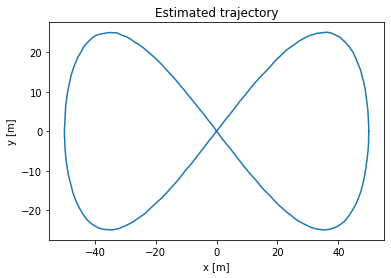

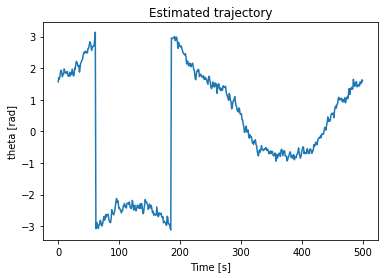

In [16]:
e_fig = plt.figure()
ax = e_fig.add_subplot(111)
ax.plot(x_est[:, 0], x_est[:, 1])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Estimated trajectory')
plt.show()

e_fig = plt.figure()
ax = e_fig.add_subplot(111)
ax.plot(t[:], x_est[:, 2])
ax.set_xlabel('Time [s]')
ax.set_ylabel('theta [rad]')
ax.set_title('Estimated trajectory')
plt.show()